In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'

In [3]:
model = VGG16()

model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [4]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    
    image = img_to_array(image)
    
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    image = preprocess_input(image)
    
    feature = model.predict(image, verbose=0)
    
    image_id = img_name.split('.')[0]
    
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1722759517.804046     104 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [5]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [7]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
mapping = {}

for line in tqdm(captions_doc.split('\n')):
    
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    
    image_id = image_id.split('.')[0]
    
    caption = " ".join(caption)
    
    if image_id not in mapping:
        mapping[image_id] = []
        
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(mapping)

8091

In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            
            caption = captions[i]
            
            caption = caption.lower()
             
            caption = caption.replace('[^A-Za-z]', '')
            
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [11]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
clean(mapping)

In [13]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

40455

In [16]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size

8485

In [19]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [21]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                
                for i in range(1, len(seq)):
                    
                    in_seq, out_seq = seq[:i], seq[i]
                    
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

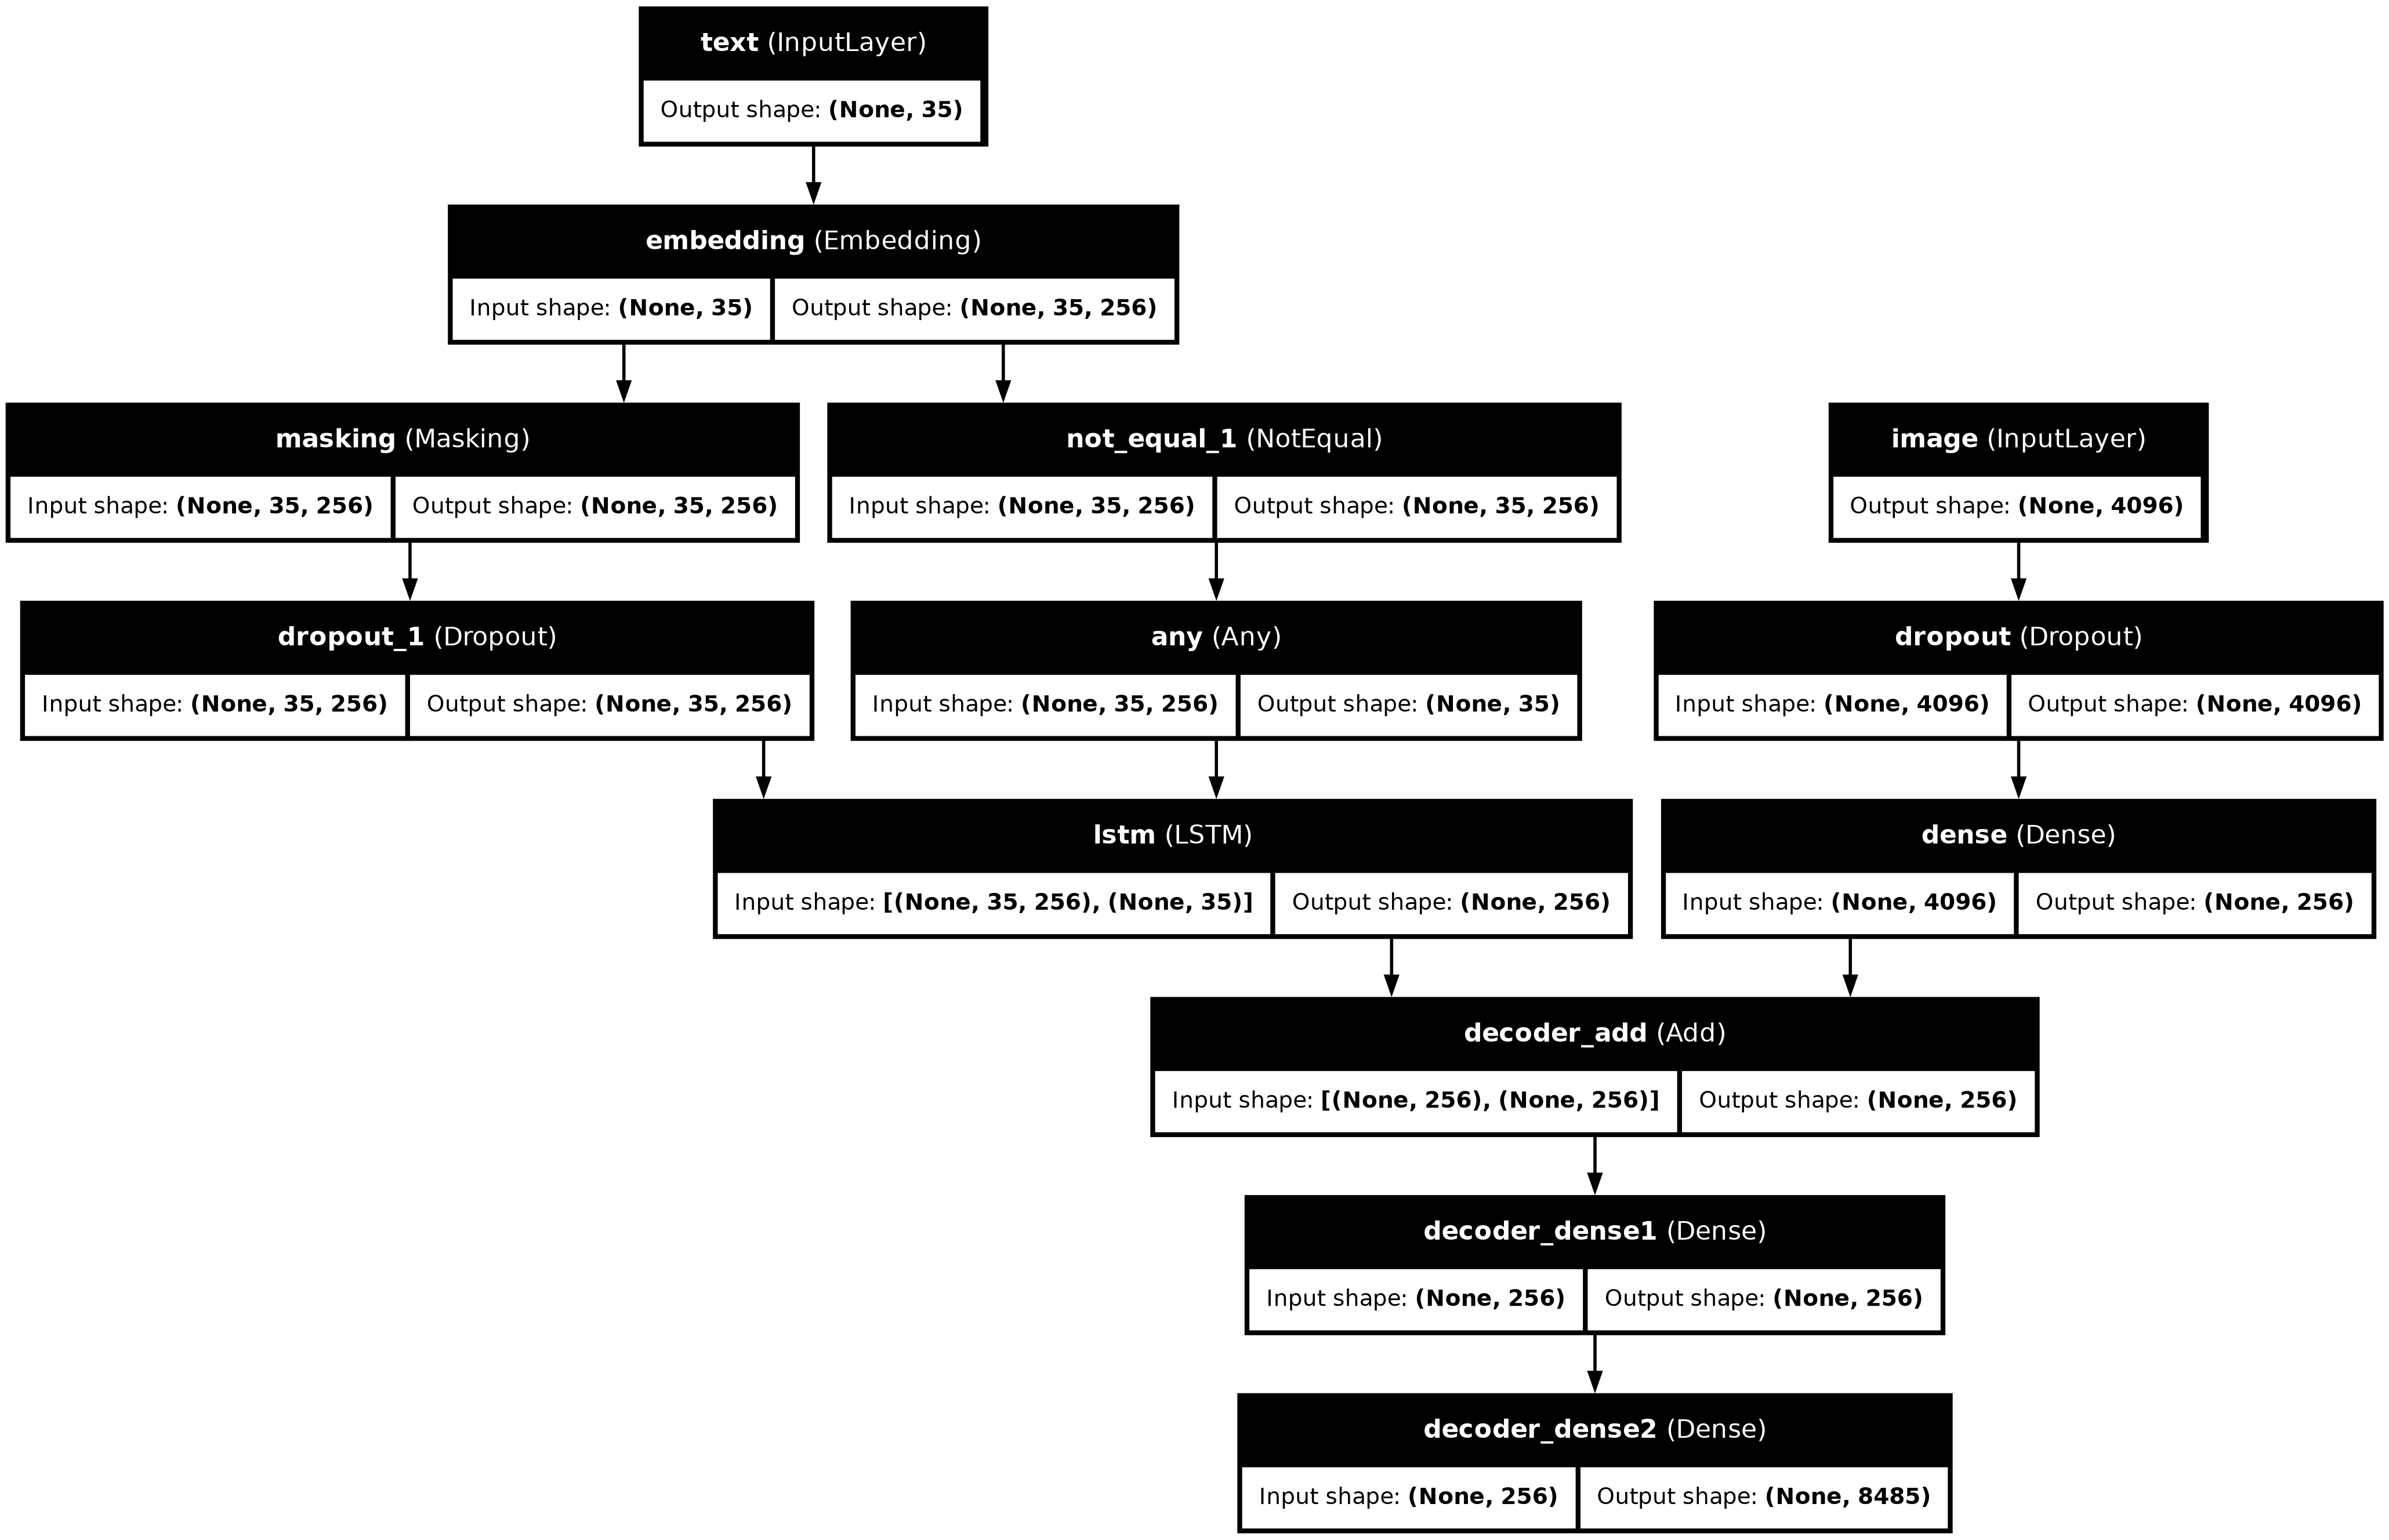

In [22]:
from keras.layers import Masking

inputs1 = Input(shape=(4096,),name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,),name="text")
se1 = Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2 = Masking(mask_value=0.0)(se1)
se3 = Dropout(0.4)(se2)
se4 = LSTM(256, return_sequences=False)(se3)

decoder1 = add([fe2, se4], name="decoder_add")
decoder2 = Dense(256, activation='relu', name="decoder_dense1")(decoder1)
outputs = Dense(vocab_size, activation='softmax', name="decoder_dense2")(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True, show_layer_names=True)

In [23]:
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 250ms/step - loss: 5.7886
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 248ms/step - loss: 4.0945
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 248ms/step - loss: 3.5988
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 245ms/step - loss: 3.3104
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 246ms/step - loss: 3.1069
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 247ms/step - loss: 2.9558
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 247ms/step - loss: 2.8414
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 245ms/step - loss: 2.7469
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 246ms/step - loss: 2.6665
227/227 ━━━━━━━━━━━━━━━━━━━━ 54s 236ms/step - loss: 2.6038
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 247ms/step - loss: 2.5448
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 248ms/step - loss: 2.4913
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 247ms/step - loss: 2.4403
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 245ms/step - loss: 2.3949
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 248ms/step - loss: 2.3561
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 247ms/step - loss: 2.3180
227/227 ━━━━━━━━━━━━━━━━━━━━ 56s 247ms/step - loss: 2.27

In [24]:
model.save(WORKING_DIR+'/best_model.h5')

In [25]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [26]:
def predict_caption(model, image, tokenizer, max_length):
    
    in_text = 'startseq'
    
    for i in range(max_length):
        
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        
        sequence = pad_sequences([sequence], max_length)
        
        yhat = model.predict([image, sequence], verbose=0)
        
        yhat = np.argmax(yhat)
        
        word = idx_to_word(yhat, tokenizer)
        
        if word is None:
            break
            
        in_text += " " + word
        
        if word == 'endseq':
            break
      
    return in_text

In [27]:
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = list(), list()

for key in tqdm(test):
    
    captions = mapping[key]
    
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    
    actual.append(actual_captions)
    predicted.append(y_pred)
    
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.545705
BLEU-2: 0.322802


In [28]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
        
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs playing with each other on the dirt endseq


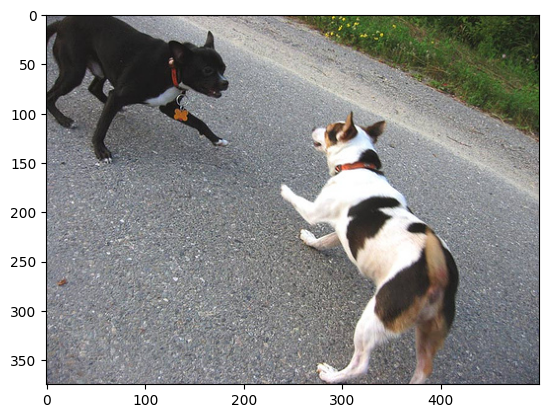

In [30]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq black dog running in the surf endseq
startseq black lab with tags frolicks in the water endseq
startseq dog splashes in the water endseq
startseq the black dog runs through the water endseq
startseq this is black dog splashing in the water endseq
--------------------Predicted--------------------
startseq black dog is swimming in the water endseq


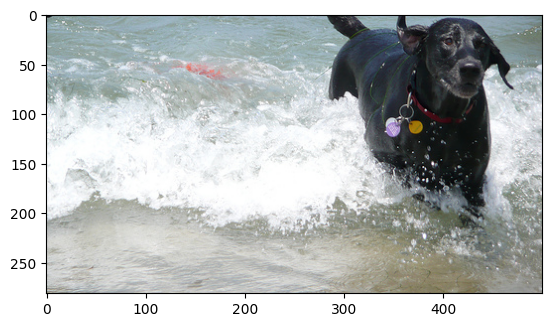

In [31]:
generate_caption("1022975728_75515238d8.jpg")

---------------------Actual---------------------
startseq two constructions workers sit on beam taking break endseq
startseq two construction workers are sitting up on the side of building endseq
startseq two construction workers sitting on an i-beam endseq
startseq two construction workers take seat on steel beam endseq
startseq two men take break from construction endseq
--------------------Predicted--------------------
startseq man in red shirt and sunglasses skateboarding endseq


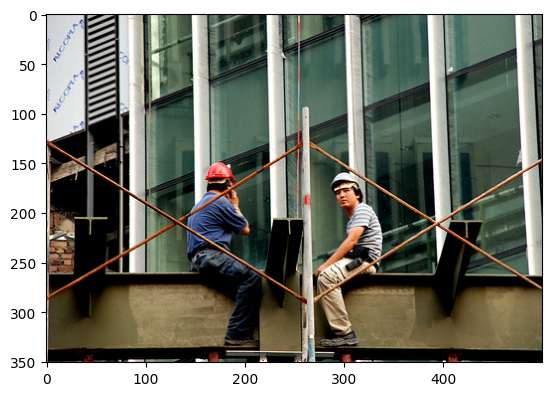

In [32]:
generate_caption("1055753357_4fa3d8d693.jpg")

---------------------Actual---------------------
startseq boy descends off the end of high diving board endseq
startseq child jumps off high diving board into the pool endseq
startseq kid jumps off the diving board and into the swimming pool below endseq
startseq little kid is jumping off high dive at the pool endseq
startseq the boy is jumping off high diving board into the pool endseq
--------------------Predicted--------------------
startseq man dives into pool endseq


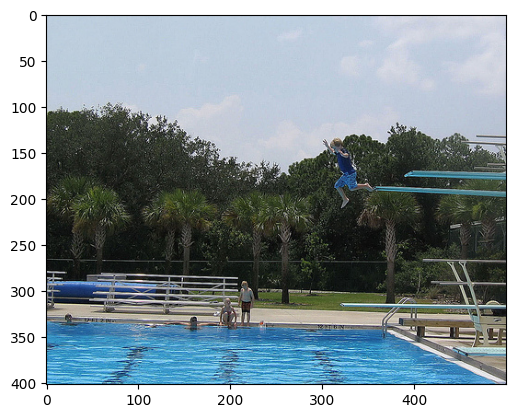

In [33]:
generate_caption("1057089366_ca83da0877.jpg")

---------------------Actual---------------------
startseq crowd watching air balloons at night endseq
startseq group of hot air balloons lit up at night endseq
startseq people are watching hot air balloons in the park endseq
startseq people watching hot air balloons endseq
startseq seven large balloons are lined up at nighttime near crowd endseq
--------------------Predicted--------------------
startseq people are watching hot air balloon endseq


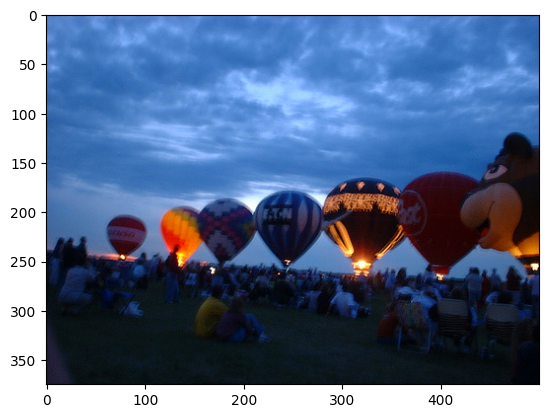

In [34]:
generate_caption("107318069_e9f2ef32de.jpg")

---------------------Actual---------------------
startseq man in brown shirt and dark shorts plays on the beach with his two black dogs endseq
startseq man in shorts with two black dogs holds ball throwing toy at the beach endseq
startseq man playing with two black dogs on the beach endseq
startseq man with two dogs on beach endseq
startseq man at the beach with two dogs endseq
--------------------Predicted--------------------
startseq man and dog playing catch in the sand endseq


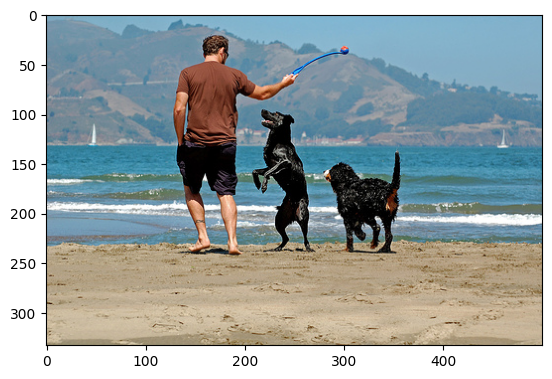

In [35]:
generate_caption("1075867198_27ca2e7efe.jpg")